In [57]:
#导入核心库
import tensorflow as tf
import numpy as np # 矩阵处理
import matplotlib.pyplot as plt # 画图
print('Tensorflow ver:',tf.__version__) # 导入完成！

Tensorflow ver: 2.1.0


In [58]:
strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [59]:
#后面很多核心函数都有优化参数，根据性能自动选择
AUTO = tf.data.experimental.AUTOTUNE
print('AUTO:',AUTO)


IMAGE_SIZE = [512,512] #手动修改此处图像大小，进行训练
WIDTH = IMAGE_SIZE[0]
HEIGHT = IMAGE_SIZE[1]
CHANNELS = 3
# label数字对应CLASSES下标，得到label名字
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'
           ]
NUM = 5

AUTO: -1


In [60]:
# 加载官方数据集
try: #Running in Kaggle kernel
    from kaggle_datasets import KaggleDatasets
    BASE = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')
except ModuleNotFoundError: # Running at my mac
    BASE = None

PATH_SELECT = { # 根据图像大小选择路径
    192: BASE + '/tfrecords-jpeg-192x192',
    224: BASE + '/tfrecords-jpeg-224x224',
    331: BASE + '/tfrecords-jpeg-331x331',
    512: BASE + '/tfrecords-jpeg-512x512'
}
IMAGE_PATH = PATH_SELECT[512]

#此处利用tf.io的库函数
#读出文件集方式很多种，也可以用os+re库进行
TRAINING_FILENAMES = tf.io.gfile.glob(IMAGE_PATH + '/train/*.tfrec')

In [61]:
def load_dataset(filenames, labeled=True, ordered=False):
    #ordered参数是指并行读取数据时不必在意是否按照原来顺序，加快速度
    #顺序不重要的= =

    #不在意顺序预处理
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False #详见help

    #利用API导入初始TFrec文件集数据
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    #设置dataset，让他保持并行读出来的顺序就行了
    dataset = dataset.with_options(ignore_order)
    #根据label决定传入带标签的解析函数，还是不带标签（test只有id）的解析函数
    dataset = dataset.map(read_labeled_tfrecord if labeled
                     else read_unlabeled_tfrecord, 
                     num_parallel_calls=AUTO)
    return dataset #现在dataset的每个data有两个部分了，一个是image，一个是class或id号

def data_augmentation(image, label):
    #所谓数据扩容，就是把原来的照片左移或右移，或上下左右反转一下，就得到了“新”图像
    #此方法利用了现实世界的平移不变形和空间不变形

    image = tf.image.random_flip_left_right(image) 
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.3)

    # 还有下列api进行更无聊的处理
    # 'random_contrast', 对比度
    # 'random_crop', 缩放
    # 'random_hue', 色相
    # 'random_jpeg_quality',  图片质量
    # 'random_saturation' 饱和度
    return image, label   

def decode_image(image_data):
    #由于给的图像是jpeg格式，故用对应api进行处理。
    #为什么要decode，因为他把图片写成bytes串了
    image = tf.image.decode_jpeg(image_data, channels=3)
    #得到tf.Tensor形式的image
    image = tf.cast(image, tf.float32)
    image /= 255.0
    #将image的每个数值调整在[0,1]之间，方便训练
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    #reshape此部非常重要，调试的时候被坑了，老是说什么shape不匹配
    return image

def read_labeled_tfrecord(example):
    FEATURE = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)  
    }
    example = tf.io.parse_single_example(example, FEATURE)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label #返回一个以 图像数组和标签形式的数据集

def read_unlabeled_tfrecord(example):
    FEATURE = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "id": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, FEATURE)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

def show_image(sample,name,i):
    label = sample[1].numpy()
    # 开始绘图
    plt.title(name+':'+CLASSES[label])
    
    image = sample[0].numpy()

    plt.axis('off')
    plt.imshow(image)
    plt.savefig(name+'{}.jpg'.format(i))
    plt.show()


In [62]:
dataset = load_dataset(TRAINING_FILENAMES, labeled=True).take(3)
aug = dataset.map(data_augmentation)

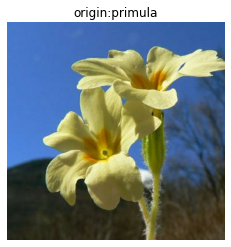

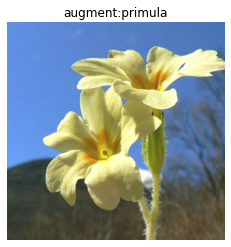

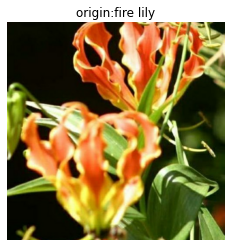

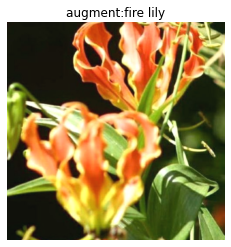

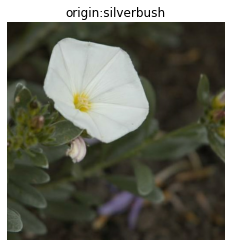

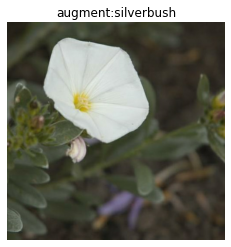

In [63]:
for index,sample in enumerate(iter(dataset)):
    show_image(sample,"origin",index)
    aug_sample=data_augmentation(sample[0],sample[1])
    show_image(aug_sample,"augment",index)

